# Introducción

En el siguiente trabajo vamos a usar los datos etiquetados y no etiquetados para elaborar clasificadores semi y no supervisados.

Primero vamos a retomar lo que hicimos en el práctico combinado de Analisis y Visualización y Curación y vamos a armar dos grafos distintos con dos criterios distintos. Uno de usuarios según los retweets y otro con un criterio elegido por ustedes.

Luego vamos a correr un algoritmo para encontrar comunidades en esos grafos. Las comunidades nos van a permitir dividir el conjunto de entrenamiento en clusters.

Una vez que tenemos las comunidades/clusters definidos, debemos asignar cada uno a una clase. Cada elemento perteneciente a una comunidad asociada a una clase será etiquetado como de esa clase. Luego usaremos esos ejemplos para entrenar nuestro clasificador.

Vamos a hacer esto para los tres tópicos: aborto, cambio climático y feminismo.

In [5]:
import pandas as pd
# permite que una misma celda imprima varios resultados
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
pd.set_option('display.max_rows', 20000)
pd.set_option('display.max_columns', 20000)
pd.set_option('display.max_colwidth', -1)
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import json

from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, make_scorer, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample

!pip install contractions
import contractions
import re
from sklearn import metrics as ms

!pip install cylouvain
import cylouvain
import time
from collections import Counter

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  import sys


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
pd.set_option('display.max_colwidth', 20000)
feminism = pd.read_csv('/content/drive/My Drive/Tweeter/Datasets/feminism_tweets.csv', engine='python')

In [8]:
feminism.head()

,_id,query,tweet.created_at,tweet.id_str,tweet.full_text,tweet.text,tweet.extended_tweet.full_text,tweet.display_text_range,tweet.entities,tweet.user.id_str,tweet.user.name,tweet.user.screen_name,tweet.user.location,tweet.user.verified,tweet.user.followers_count,tweet.user.friends_count,tweet.user.listed_count,tweet.user.favorites_count,tweet.user.statuses_count,tweet.user.created_at,tweet.user.following,tweet.retweet_status,tweet.retweeted_status.created_at,tweet.retweeted_status.id_str,tweet.retweeted_status.text,tweet.retweeted_status.user.id_str,tweet.retweeted_status.user.name,tweet.retweeted_status.user.screen_name,tweet.retweeted_status.user.location,tweet.retweeted_status.user.verified,tweet.retweeted_status.user.followers_count,tweet.retweeted_status.user.friends_count,tweet.retweeted_status.user.listed_count,tweet.retweeted_status.user.favorites_count,tweet.retweeted_status.user.statuses_count,tweet.retweeted_status.user.created_at,tweet.retweeted_status.user.id_str.1,tweet.retweeted_status.user.following,tweet.retweeted_status.retweet_status,tweet.retweeted_status.extended_tweet
0,ObjectId(5e1f36e5914caa46502ba871),sexism,Wed Jan 15 15:58:24 +0000 2020,1217476132041150465,"@TwoHatsHegemon @JessicaLBYRD Women witnessed Bernie attack Hillary in sexist ways in the 2016 primary. Women hid in private Facebook groups to hide from the public vitriol of the Bernie Bros. So, when Warren says something that talks of Bernie’s sexism, the 2016 primary is proof that he is sexist.",NaN,NaN,"[30,299]","{""hashtags"":[],""symbols"":[],""user_mentions"":[{""screen_name"":""TwoHatsHegemon"",""name"":""Samuel Bennett"",""id"":462247315,""id_str"":""462247315"",""indices"":[0,15]},{""screen_name"":""JessicaLBYRD"",""name"":""Jessica Byrd"",""id"":49759849,""id_str"":""49759849"",""indices"":[16,29]}],""urls"":[]}",394202170,D,m1ssw0rld,NaN,False,3,12,0,NaN,20,Wed Oct 19 18:36:29 +0000 2011,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ObjectId(5e1f36e5914caa46502ba873),sexism,Wed Jan 15 15:58:20 +0000 2020,1217476118141259778,"RT @onesarahjones: you know who wrote great pieces about all this? @bridgetgillard and @rtraister: https://t.co/Dl3UJQvqZN, https://t.co/TO…",NaN,NaN,"[0,140]","{""hashtags"":[],""symbols"":[],""user_mentions"":[{""screen_name"":""onesarahjones"",""name"":""Sarah Jones"",""id"":113250460,""id_str"":""113250460"",""indices"":[3,17]},{""screen_name"":""bridgetgillard"",""name"":""Bridget Read"",""id"":309747601,""id_str"":""309747601"",""indices"":[67,82]},{""screen_name"":""rtraister"",""name"":""Rebecca Traister"",""id"":19086859,""id_str"":""19086859"",""indices"":[87,97]}],""urls"":[{""url"":""https://t.co/Dl3UJQvqZN"",""expanded_url"":""https://www.thecut.com/2020/01/elizabeth-warren-bernie-sanders-conflict-has-no-winners.html"",""display_url"":""thecut.com/2020/01/elizab…"",""indices"":[99,122]}]}",1175677064415858689,Under the Neem Tree,neem_the,NaN,False,15,186,0,NaN,3186,Sun Sep 22 07:44:11 +0000 2019,False,NaN,Wed Jan 15 15:35:02 +0000 2020,1.217470e+18,NaN,1.132505e+08,Sarah Jones,onesarahjones,"New York, NY",True,42521.0,2018.0,788.0,NaN,28129.0,Thu Feb 11 05:13:24 +0000 2010,1.132505e+08,False,NaN,NaN
2,ObjectId(5e1f36e5914caa46502ba875),sexism,Wed Jan 15 15:58:19 +0000 2020,1217476114223894529,RT @JessicaValenti: Worth noting: Any time Warren has spoken about sexism - like being fired for being pregnant or being sexually harassed…,NaN,NaN,"[0,139]","{""hashtags"":[],""symbols"":[],""user_mentions"":[{""screen_name"":""JessicaValenti"",""name"":""Jessica Valenti"",""id"":4099171,""id_str"":""4099171"",""indices"":[3,18]}],""urls"":[]}",64544617,New Year Same Nique,17ShortFuse,Green Bay,False,532,1382,31,NaN,203747,Mon Aug 10 23:05:29 +0000 2009,False,NaN,Wed Jan 15 03:04:44 +0000 2020,1.217281e+18,NaN,4.099171e+06,Jessica Valenti,JessicaValenti,"Brooklyn, NY",True,277054.0,1206.0,4956.0,NaN,3767.0,Wed Apr 11 00:45:08 +0000 2007,4.099171e+06,False,NaN,NaN
3,ObjectId

### Cobertura

In [9]:
def get_text(tweet):
    if tweet["tweet.retweeted_status.text"] == tweet["tweet.retweeted_status.text"]:
        return tweet["tweet.retweeted_status.text"]
    else:
        return tweet["tweet.full_text"]

In [10]:
def get_text2(tweet):
    if tweet["tweet.extended_tweet.full_text"] == tweet["tweet.extended_tweet.full_text"]:  
        return tweet["tweet.extended_tweet.full_text"]
    else:
        return tweet["full_text"]

#### Feminism

In [11]:
feminism["full_text"] = feminism.apply(get_text, axis=1)

In [12]:
feminism["full_text2"] = feminism.apply(get_text2, axis=1)

In [13]:
feminism["full_text2"] = feminism["full_text2"].fillna(0)
feminism['category'] = np.where(feminism.full_text2 == 0 , 0, 1)
feminism['full_text2'] = np.where(feminism['category'] == 0, feminism['tweet.text'], feminism['full_text2'])

In [14]:
print(len(feminism["tweet.full_text"]))
print(len(feminism["full_text2"].dropna()))

634383
634383


## Grafo

#### De retweets

In [15]:
retweets = feminism.dropna(subset=["tweet.retweeted_status.user.id_str"]) #Subset lo que hace es me elimina la fila si el nan está en la columna que le paso como parámetro
len(retweets["tweet.retweeted_status.user.id_str"])

461646

In [16]:
full_g = nx.Graph()
vertex_ids = set()


for user1, user2 in zip(retweets["tweet.user.id_str"], retweets["tweet.retweeted_status.user.id_str"]):
    full_g.add_edge(user1, user2)

In [17]:
n = len(full_g.nodes)
m = len(full_g.edges)
complete = n * (n-1) / 2

print("Nodos: {:.0f}".format(n))
print("Ejes: {:.0f}".format(m))

Nodos: 322200
Ejes: 443633


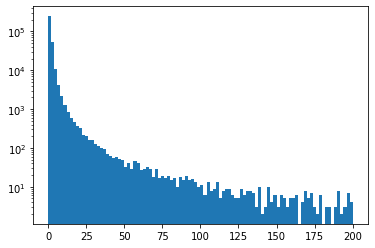

In [18]:
degrees = np.array([full_g.degree(node) for node in full_g.nodes()])

plt.hist(degrees, range=(0, 200), bins=100);
plt.semilogy();

In [19]:
def subgraph_strong_nodes(g, n):
    """
    Devuelve subgrafo con nodos de grado mayor a n
    """
    good_nodes = [node for node in g.nodes() if g.degree(node) >= n]
    
    return g.subgraph(good_nodes)

In [20]:
g = subgraph_strong_nodes(full_g, 5)

print("Nos quedan {:.2f}M nodos (antes eran {:.2f}M)".format(
    len(g.nodes) / 1e6,
    len(full_g.nodes) / 1e6
))
print("Componentes conexas = {}".format(len(list(nx.connected_components(g)))))

Nos quedan 0.02M nodos (antes eran 0.32M)
Componentes conexas = 1960


In [21]:
components = list(nx.connected_components(g))

print("Componentes conexas = {}".format(len(components)))

print("Componente 0  --> {:<6} usuarios".format(len(components[0])))

resto = [len(components[i]) for i in range(1, len(components))]
print("Restantes     --> {:<6} usuarios".format(sum(resto)))


Componentes conexas = 1960
Componente 0  --> 14668  usuarios
Restantes     --> 2156   usuarios


In [22]:
g = g.subgraph(components[0])

#### Alternativo

In [23]:
g2 = # TODO

SyntaxError: ignored

# Comunidades

Como método para detectar las comunidades vamos a usar el algoritmo de Louvain
https://es.wikipedia.org/wiki/M%C3%A9todo_de_Louvain

Louvain es un método iterativo que busca armar comunidades en función de maximizar la modularidad. A grandes rasgos, arma comunidades tales que hagan que la mayor cantidad de aristas conecten dos nodos que sean de la misma comunidad. El problema es que la solución ideal a esta modularidad es muy costosa computacionalmente. Por lo tanto, Louvain es una heurística iterativa (en cada iteración se acerca un poco más a una solución mejor sin necesariamente llegar a alcanzar una solución ideal). Al ser un método iterativo no es exacto: correrlo varias veces con los mismos parámetros puede dar distintos resultados. El algoritmo termina cuando logra estabilidad, es decir, un valor de modularidad que considera aceptable.

Nosotros vamos a trabajar con un parámetro específico de este algoritmo que es la resolución. La resolución afecta la estabilidad del sistema: a mayor resolución, se necesitan más iteraciones para lograr estabilidad. En particular, lo que a nosotros nos interesa, es que **a mayor resolución, el algoritmo encuentra menos comunidades de mayor tamaño** (se polariza).

Lo que nosotros queremos hacer es encontrar el menor valor de la resolución que nos de como resultado únicamente  dos comunidades polares que tengan más de una cierta cantidad de usuarios (definida en la variable users_threshold)

In [24]:
# https://pypi.org/project/cylouvain/


# Devuelve todas las particiones según la resolución. Si hay una particion ideal
# (la menor particion que genere 2 o menos comunidades), la devuelve. Sino devuelve -1
def findPartitions(g, user_threshold, resolutions):
    resolutions.sort()
    best_resolution = -1
    found_best = False
    partitions = {}
    for resolution in resolutions:
        print("resolución {:.2f}".format(resolution), end="")

        partition = cylouvain.best_partition(g, resolution=resolution)

        num_partitions = len(set(partition.values()))
        counter = Counter(partition.values())

        # Aca le está diciendo que cuente cuantas son las que tienen usuarios mayores al threshold
        important_partitions = len([_ for x in counter.items() if x[1] > user_threshold])


        if important_partitions <= 2 and not found_best:
            best_resolution = resolution
            found_best = True
            
        print("---> {} particiones ({} con más de {} usuarios)".format(
            num_partitions,
            important_partitions,
            user_threshold,
        ))
        #print("Tiempo: {:.2f} minutos".format((end - begin) / 60))
        partitions[resolution] = partition
    return partitions, best_resolution

In [25]:
# Ejemplo
partitions, resolution = findPartitions(g, 100,  [1.0, 1.5, 2.0, 3.0, 5.0, 6.0, 7.0, 10.0, 15.0])

resolución 1.00---> 25 particiones (13 con más de 100 usuarios)
resolución 1.50---> 22 particiones (12 con más de 100 usuarios)
resolución 2.00---> 21 particiones (10 con más de 100 usuarios)
resolución 3.00---> 20 particiones (8 con más de 100 usuarios)
resolución 5.00---> 10 particiones (7 con más de 100 usuarios)
resolución 6.00---> 10 particiones (5 con más de 100 usuarios)
resolución 7.00---> 9 particiones (5 con más de 100 usuarios)
resolución 10.00---> 11 particiones (4 con más de 100 usuarios)
resolución 15.00---> 7 particiones (4 con más de 100 usuarios)


In [26]:
resolution

-1

In [27]:
# Aca paso del formato lista de tupla<nodo, Número de comunidad> a un mapa que para cada comunidad tiene la lista de los nodos que pertenecen
if resolution != -1:
    partition = partitions[resolution]
    partition_to_ids = {partition_number:[] for partition_number in range(len(set(partition.values())))}

    num_partitions = len(set(partition.values()))
    for user_id, user_partition in partition.items():
        partition_to_ids[user_partition].append(user_id)
else:
    print("Hay más de dos particiones principales")

Hay más de dos particiones principales


### Ejercicio 1

Prueben distintos valores de user_threshold y distintas resoluciones evaluando cosas como cuantos (y cuales) nodos del grafo (sean los nodos usuarios u otra cosa) les quedan por fuera de las dos comunidades más grandes (no necesariamente es malo que queden muchos nodos afuera si verdaderamente no tienen una postura clara sobre el tópico); que proporcion tienen esas dos comunidades más grandes: ¿son parejas entre sí o no?; en el caso de que los nodos sean usuarios, además de los usuarios, ¿son parejas la cantidad de tweets que postean esos usuarios? ¿Cuántos tweets hay de cada comunidad?

In [347]:
partitions, resolution = findPartitions(g, 1000,  [1.0, 1.5, 2.0, 3.0, 5.0, 6.0, 7.0, 10.0, 15.0, 20.0, 25.0, 30.0])

resolución 1.00---> 25 particiones (5 con más de 1000 usuarios)
resolución 1.50---> 22 particiones (5 con más de 1000 usuarios)
resolución 2.00---> 21 particiones (4 con más de 1000 usuarios)
resolución 3.00---> 20 particiones (3 con más de 1000 usuarios)
resolución 5.00---> 10 particiones (3 con más de 1000 usuarios)
resolución 6.00---> 10 particiones (3 con más de 1000 usuarios)
resolución 7.00---> 9 particiones (3 con más de 1000 usuarios)
resolución 10.00---> 11 particiones (2 con más de 1000 usuarios)
resolución 15.00---> 7 particiones (2 con más de 1000 usuarios)
resolución 20.00---> 5 particiones (2 con más de 1000 usuarios)
resolución 25.00---> 4 particiones (2 con más de 1000 usuarios)
resolución 30.00---> 5 particiones (1 con más de 1000 usuarios)


In [348]:
resolution

10.0

In [349]:
# Aca paso del formato lista de tupla<nodo, Número de comunidad> a un mapa que para cada comunidad tiene la lista de los nodos que pertenecen
if resolution != -1:
    partition = partitions[30] #acá usamos la resolución 25
    partition_to_ids = {partition_number:[] for partition_number in range(len(set(partition.values())))}

    num_partitions = len(set(partition.values()))
    for user_id, user_partition in partition.items():
        partition_to_ids[user_partition].append(user_id)
else:
    print("Hay más de dos particiones principales")

Cantidad de Usuarios y cantidad de Tweets por partición.

Partition 1 y 2 son las comunidades mas grandes.

In [350]:
comunidad, tweets, comunidades, tweet_comunidad = {}, {}, {}, {}
for i in range(len(set(partition.values()))):
  comunidad[i] = partition_to_ids[i]
  tweet_comunidad[i] = retweets[retweets['tweet.user.id_str'].isin(comunidad[i])]
  comunidades[i] = len(comunidad[i])
  tweets[i] = len(tweet_comunidad[i])

com = pd.DataFrame({'users': comunidades, 'tweets': tweets}) 

In [351]:
com['tweets por usuario'] = com['tweets'] / com['users'] 
com

,users,tweets,tweets por usuario
0,46,209,4.543478
1,32,99,3.093750
2,389,1571,4.038560
3,743,4576,6.158816
4,13458,86010,6.390994


In [352]:
com.iloc[3:5]

,users,tweets,tweets por usuario
3,743,4576,6.158816
4,13458,86010,6.390994


In [353]:
com.iloc[3:5]['users'].sum() / com['users'].sum()

0.9681619852740659

### Esto es para ver qué hay en los tweets que quedan fuera de las comunidades más grandes

In [354]:
Counter(partition.values())

Counter({0: 46, 1: 32, 2: 389, 3: 743, 4: 13458})

In [355]:
users_out = [key  for (key, value) in partition.items() if value == 1]

In [357]:
retweets[retweets['tweet.user.id_str'].isin(users_out)]['full_text2'].head()

49767       RT @TakedownMRAs: @sandpitsquirtal It is a tragedy that men's self-appointed Activists deny patriarchy and toxic masculinity even exist, an…
83303      Today my Italian teacher said:"do you recommend me any show?" \nI said:"There's this show on Netflix based on AOGG."… https://t.co/hh9m5f4Yya
96613       RT @IsiHalfBlood: @AeditsKindred @academbrella @AmybethMcnulty she is always lifting women up like the amazing feminist she is, and jokes w…
121199    RT @soulisthirsty: "There was a lot of civilized talk about women's education and social reforms."\n\n"Next you'll be telling me you all burn…
121201    RT @soulisthirsty: "There was a lot of civilized talk about women's education and social reforms."\n\n"Next you'll be telling me you all burn…
Name: full_text2, dtype: object

### Ejercicio 2

Armen un script que para cada comunidad muestre datos que permitan evaluar cuan bien se ajusta a la clase a la que la queremos asignar. Algunos ejemplos pueden ser: usuarios con más cantidad de retweets, tweets más retwiteados, tweets de los usuarios con más cantidad de tweets, etc. Tiene que ser algo que de un panorama de qué es esa comunidad pero a su vez sencillo de ver y que convenza a alguien que lo ve desde afuera que usar esas comunidades puede servir.

#### Decidimos ver algunos tweets de los usuarios con mas tweets de cada comunidad. Con lo que podemos concluir que la Comunidad 1 es la que está ... y la comunidad 2 es la que esta ... del Feminismo.

In [395]:
df_comunidad1 = tweet_comunidad[3] #A favor
df_comunidad2 = tweet_comunidad[4] #En contra

In [359]:
df_comunidad1.shape, df_comunidad2.shape

((4576, 43), (86010, 43))

Generamos una lista con los 10 usuarios mas tweeteadores de la Comunidad 1 

In [360]:
list_influencers = df_comunidad1.groupby(by='tweet.user.id_str').count().sort_values(by='query', ascending=False).iloc[:10]

In [361]:
list_influencers = list_influencers.iloc[:,:0].reset_index()

### Ejemplos de tweets de uno de los usuarios con mas tweets indican que la comunidad 1 está **A favor del Feminismo**. 

    -This guy has so much respect for women ans he see them as equals 
    -He is the torchbearer of feminism

In [364]:
np.random.seed(33)
retweets[retweets['tweet.user.id_str'] == list_influencers['tweet.user.id_str'][1]].sample(4)

,_id,query,tweet.created_at,tweet.id_str,tweet.full_text,tweet.text,tweet.extended_tweet.full_text,tweet.display_text_range,tweet.entities,tweet.user.id_str,tweet.user.name,tweet.user.screen_name,tweet.user.location,tweet.user.verified,tweet.user.followers_count,tweet.user.friends_count,tweet.user.listed_count,tweet.user.favorites_count,tweet.user.statuses_count,tweet.user.created_at,tweet.user.following,tweet.retweet_status,tweet.retweeted_status.created_at,tweet.retweeted_status.id_str,tweet.retweeted_status.text,tweet.retweeted_status.user.id_str,tweet.retweeted_status.user.name,tweet.retweeted_status.user.screen_name,tweet.retweeted_status.user.location,tweet.retweeted_status.user.verified,tweet.retweeted_status.user.followers_count,tweet.retweeted_status.user.friends_count,tweet.retweeted_status.user.listed_count,tweet.retweeted_status.user.favorites_count,tweet.retweeted_status.user.statuses_count,tweet.retweeted_status.user.created_at,tweet.retweeted_status.user.id_str.1,tweet.retweeted_status.user.following,tweet.retweeted_status.retweet_status,tweet.retweeted_status.extended_tweet,full_text,full_text2,category
424021,ObjectId(5e22fe6a8869cedfa3f59b1b),gender equality,Fri Jan 10 16:58:51 +0000 2020,1215679405210533888,"RT @tiwarialok91: #EntertainerSid\n\nWhen Sid told about what he and his sisters were taught by his parents regarding gender equality,\n\nEvery…",NaN,NaN,"[0,140]","{""hashtags"":[{""text"":""EntertainerSid"",""indices"":[18,33]}],""symbols"":[],""user_mentions"":[{""screen_name"":""tiwarialok91"",""name"":""Alok Baba🔥❤"",""id"":40867791,""id_str"":""40867791"",""indices"":[3,16]}],""urls"":[]}",1210874457562075137,Divya Devis,DevisDivya,NaN,False,282,381,0,NaN,11692,Sat Dec 28 10:45:53 +0000 2019,False,NaN,Fri Jan 10 16:52:24 +0000 2020,1.215678e+18,NaN,4.086779e+07,Alok Baba🔥❤,tiwarialok91,INDIA,False,3021.0,268.0,0.0,NaN,27789.0,Mon May 18 12:59:41 +0000 2009,4.086779e+07,False,NaN,NaN,"RT @tiwarialok91: #EntertainerSid\n\nWhen Sid told about what he and his sisters were taught by his parents regarding gender equality,\n\nEvery…","RT @tiwarialok91: #EntertainerSid\n\nWhen Sid told about what he and his sisters were taught by his parents regarding gender equality,\n\nEvery…",1
264370,ObjectId(5e212c498869cedfa3f08e17),feminazis,Sat Jan 11 17:05:29 +0000 2020,1216043464841814018,"RT @IisLara: This guy has so much respect for women ans he see them as equals .👏👏🤗🤗\n\n#SidharthShukIa - Koi mujhe Aurat bole to ,I've no pro…",NaN,NaN,"[0,140]","{""hashtags"":[{""text"":""SidharthShukIa"",""indices"":[85,100]}],""symbols"":[],""user_mentions"":[{""screen_name"":""IisLara"",""name"":""Bubble ♥️"",""id"":{""$numberLong"":""1155512406488961026""},""id_str"":""1155512406488961026"",""indices"":[3,11]}],""urls"":[]}",1210874457562075137,Divya Devis,DevisDivya,NaN,False,261,374,0,NaN,10870,Sat Dec 28 10:45:53 +0000 2019,False,NaN,Sat Jan 11 17:00:13 +0000 2020,1.216042e+18,NaN,1.155512e+18,Bubble ♥️,IisLara,India,False,281.0,65.0,0.0,NaN,2629.0,Sun Jul 28 16:16:40 +0000 2019,1.155512e+18,False,NaN,NaN,"RT @IisLara: This guy has so much respect for women ans he see them as equals .👏👏🤗🤗\n\n#SidharthShukIa - Koi mujhe Aurat bole to ,I've no pro…","RT @IisLara: This guy has so much respect for women ans he see them as equals .👏👏🤗🤗\n\n#SidharthShukIa - Koi mujhe Aurat bole to ,I've no pro…",1
520439,ObjectId(5e2432088869cedfa3f8a7e8),feminism,Sun Jan 19 10:33:35 +0000 2020,1218843942801686528,RT @NivishaK: He is the torchbearer of feminism \n\n#ChartbusterSid https://t.co/0iiHh4cZVw,NaN,NaN,"[0,90]","{""hashtags"":[{""text"":""ChartbusterSid"",""indices"":[51,66]}],""symbols"":[],""user_mentions"":[{""screen_name"":""NivishaK"",""name"":""Malti || Chhapaak"",""id"":{""$numberLong"":""928216823497072641""},""id_str"":""928216823497072641"",""indices"":[3,12]}],""urls"":[{""url"":""https://t.co/0iiHh4cZVw"",""expanded_url"":""https://twitter.com/1amH4rshBhatt/status/1208997712026189825"",""display_url"":""twitter.com/1amH

### Comunidad 2

In [365]:
list_influencers2 = df_comunidad2.groupby(by='tweet.user.id_str').count().sort_values(by='query', ascending=False).iloc[:10]
list_influencers2 = list_influencers2.iloc[:,:1].reset_index()

In [366]:
list_influencers2

,tweet.user.id_str,_id
0,793873487668576256,147
1,920122212,137
2,15169183,128
3,1113498540351741952,111
4,2713128301,111
5,3762836175,108
6,1144246338726637568,107
7,777892431148752896,95
8,242944363,95
9,18825080,94


### Ejemplos de tweets de uno de los usuarios con mas tweets indican que la comunidad 2 está **en contra del Feminismo**. 

    -sexism is undeniably real and harmful but certain people have a habit of disingenuously evoking it to win arguments, and…	
    -You claim you're a feminist, and yet you're implying I'm complicit in the mysterious deaths of all my wealthy former hus…

In [368]:
np.random.seed(30)
retweets[retweets['tweet.user.id_str'] == list_influencers2['tweet.user.id_str'][1]].sample(5)

,_id,query,tweet.created_at,tweet.id_str,tweet.full_text,tweet.text,tweet.extended_tweet.full_text,tweet.display_text_range,tweet.entities,tweet.user.id_str,tweet.user.name,tweet.user.screen_name,tweet.user.location,tweet.user.verified,tweet.user.followers_count,tweet.user.friends_count,tweet.user.listed_count,tweet.user.favorites_count,tweet.user.statuses_count,tweet.user.created_at,tweet.user.following,tweet.retweet_status,tweet.retweeted_status.created_at,tweet.retweeted_status.id_str,tweet.retweeted_status.text,tweet.retweeted_status.user.id_str,tweet.retweeted_status.user.name,tweet.retweeted_status.user.screen_name,tweet.retweeted_status.user.location,tweet.retweeted_status.user.verified,tweet.retweeted_status.user.followers_count,tweet.retweeted_status.user.friends_count,tweet.retweeted_status.user.listed_count,tweet.retweeted_status.user.favorites_count,tweet.retweeted_status.user.statuses_count,tweet.retweeted_status.user.created_at,tweet.retweeted_status.user.id_str.1,tweet.retweeted_status.user.following,tweet.retweeted_status.retweet_status,tweet.retweeted_status.extended_tweet,full_text,full_text2,category
181468,ObjectId(5e203ec18869cedfa3edec7b),sexism,Thu Jan 16 10:35:52 +0000 2020,1217757353145225216,RT @hasanthehun: i love to showcase how seriously i take the issue of sexism by strategically waiting to leak accusations of my close polit…,NaN,NaN,"[0,140]","{""hashtags"":[],""symbols"":[],""user_mentions"":[{""screen_name"":""hasanthehun"",""name"":""hasanabi"",""id"":326756275,""id_str"":""326756275"",""indices"":[3,15]}],""urls"":[]}",920122212,Snowberrys 🥀,MsVarunDhawan,"Skokie, IL",False,903,944,61,NaN,205027,Fri Nov 02 01:00:58 +0000 2012,False,NaN,Thu Jan 16 10:15:16 +0000 2020,1.217752e+18,NaN,3.267563e+08,hasanabi,hasanthehun,"Istanbul, LA, NYC",True,209167.0,1517.0,785.0,NaN,19417.0,Thu Jun 30 12:52:46 +0000 2011,3.267563e+08,False,NaN,NaN,RT @hasanthehun: i love to showcase how seriously i take the issue of sexism by strategically waiting to leak accusations of my close polit…,RT @hasanthehun: i love to showcase how seriously i take the issue of sexism by strategically waiting to leak accusations of my close polit…,1
269299,ObjectId(5e21371c8869cedfa3f0b35b),feminists,Tue Jan 14 07:56:18 +0000 2020,1216992421113929728,"RT @kthalps: Shout out to all the Pseudo feminists &amp; allies who, while attributing any &amp; all criticism of Hillary Clinton to misogyny &amp; sex…",NaN,NaN,"[0,152]","{""hashtags"":[],""symbols"":[],""user_mentions"":[{""screen_name"":""kthalps"",""name"":""Katie Halper"",""id"":15859912,""id_str"":""15859912"",""indices"":[3,11]}],""urls"":[]}",920122212,Snowberrys 🥀,MsVarunDhawan,"Skokie, IL",False,910,944,62,NaN,205991,Fri Nov 02 01:00:58 +0000 2012,False,NaN,Tue Jan 14 06:21:32 +0000 2020,1.216969e+18,NaN,1.585991e+07,Katie Halper,kthalps,"Manhattan, NY",True,77863.0,6908.0,1262.0,NaN,58028.0,Fri Aug 15 04:22:01 +0000 2008,1.585991e+07,False,NaN,NaN,"RT @kthalps: Shout out to all the Pseudo feminists &amp; allies who, while attributing any &amp; all criticism of Hillary Clinton to misogyny &amp; sex…","RT @kthalps: Shout out to all the Pseudo feminists &amp; allies who, while attributing any &amp; all criticism of Hillary Clinton to misogyny &amp; sex…",1
268901,ObjectId(5e2136fb8869cedfa3f0afb1),sexism,Fri Jan 17 04:14:10 +0000 2020,1218023681219268608,"RT @nataliesurely: sexism is undeniably real and harmful but certain people have a habit of disingenuously evoking it to win arguments, and…",NaN,NaN,"[0,140]","{""hashtags"":[],""symbols"":[],""user_mentions"":[{""screen_name"":""nataliesurely"",""name"":""Natalie Shure"",""id"":243800816,""id_str"":""243800816"",""indices"":[3,17]}],""urls"":[]}",920122212,Snowberrys 🥀,MsVarunDhawan,"Skokie, IL",False,910,944,62,NaN,205992,Fri Nov 02 01:00:58 +0000 2012,False,NaN,Thu Jan 16 04:54:33 +0000 2020,1.217671e+18,NaN,2.438008e+08,Natalie Shure,nataliesurely,"Boston, MA",True,49010.0,3668.0,594.0,NaN,37274.0,Thu Jan 27 21:02:50 +00

### Ejercicio 3

Hagan una nube de palabras con los tweets de cada comunidad y analicen cuan fácil o difícil es inferir la clase de esa comunidad mirando la nube.

In [369]:
def preprocesar(text, keep_hashtags=True, remove_numbers=True):
    
    text = contractions.fix(text) 
    
    toks = tokenizer.tokenize(text)
    
    ret = []
    for tok in toks:
                
        if re.match('https?://[A-Za-z0-9./]+',tok):
            continue

        if re.match('[A-Za-z0-9./]+@[A-Za-z0-9./]+',tok):
            continue
            
        if re.match(r'[^\w\s\#,]',tok): #emoji
            continue
            
        if re.match('[^?!.,]*[?.!,]$',tok): #puntuaciones
            continue

        if re.match('rt',tok): #puntuaciones
            continue
        
        if tok.isnumeric() and remove_numbers:
            continue
        ret.append(tok)
    return " ".join(ret)

In [370]:

from nltk.tokenize import TweetTokenizer
tokenizer = TweetTokenizer(preserve_case=False, reduce_len=True, strip_handles=True)
df_comunidad1["full_text2"] = df_comunidad1["full_text2"].apply(lambda x: preprocesar(x))
df_comunidad2["full_text2"] = df_comunidad2["full_text2"].apply(lambda x: preprocesar(x))

In [371]:
#desvectorizar
def desvectorizar(lista, dictionary) :
  result = []
  for tweet in lista :
    i = 0
    #print("Lista " +str(tweet))
    for palabra in tweet :
      if palabra > 0 :
        for y in range(palabra):
          result.append(dictionary[i])
      i = i+1
  
  #print("Resultado: "+str(result))
  return result

In [372]:
def get_feature_names(input_retweets):
    text = input_retweets["full_text2"]

    vectorizer = CountVectorizer(
        binary=True, min_df=0.004, max_df=0.7, ngram_range=(1, 3)
        #stop_words=stopwords.words('spanish')
    )
    X_result = vectorizer.fit_transform([*text])

    return X_result, vectorizer.get_feature_names()

In [373]:
#Comunidad 1
VEC_BOW_1, diccionario_feminism_1 = get_feature_names(df_comunidad1)
bag_of_words_feminism_1 = desvectorizar(VEC_BOW_1.toarray(), diccionario_feminism_1)
allcomments_1 = " ".join(bag_of_words_feminism_1)

#Comunidad 2
VEC_BOW_2, diccionario_feminism_2 = get_feature_names(df_comunidad2)
bag_of_words_feminism_2 = desvectorizar(VEC_BOW_2.toarray(), diccionario_feminism_2)
allcomments_2 = " ".join(bag_of_words_feminism_2)

##BOW Comunidad 1

<Figure size 720x720 with 0 Axes>

Text(0.5, 1.0, 'All Tweets Wordcount')

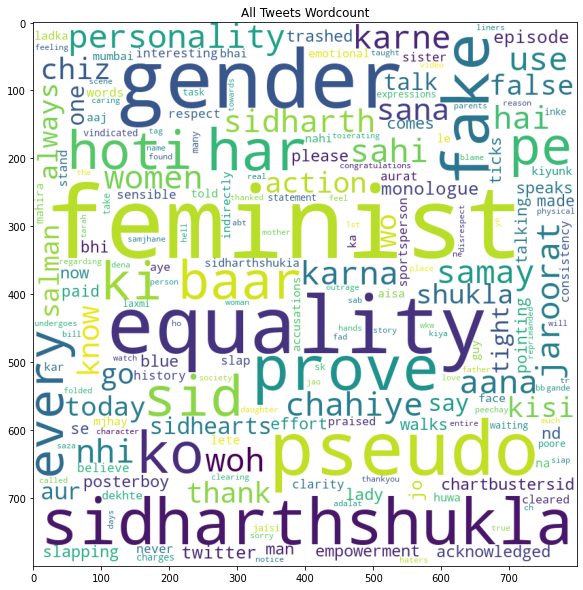

In [374]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud,STOPWORDS
wordcloud1 = WordCloud(collocations=False, width = 800, height = 800,
                    background_color ='white',
                    stopwords = STOPWORDS,
                    min_font_size = 12).generate(allcomments_1)

# plot the WordCloud image                        
plt.figure(figsize = (10, 10), facecolor = None)
plt.imshow(wordcloud1)
plt.title("All Tweets Wordcount")
plt.show()

##BOW Comunidad 2

<Figure size 720x720 with 0 Axes>

Text(0.5, 1.0, 'All Tweets Wordcount')

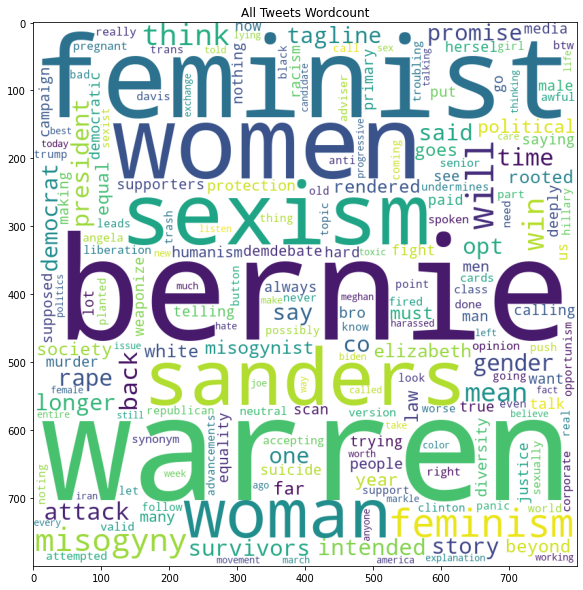

In [375]:
wordcloud2 = WordCloud(collocations=False, width = 800, height = 800,
                    background_color ='white',
                    stopwords = STOPWORDS,
                    min_font_size = 12).generate(allcomments_2)

# plot the WordCloud image             
plt.figure(figsize = (10, 10), facecolor = None)
plt.imshow(wordcloud2)
plt.title("All Tweets Wordcount")
plt.show()

### Ejercicio 4

Decidan una clase para cada comunidad. Justifiquen su decisión planteando cuán ajustada les parece que es la asignación en función de los ejercicios anteriores

Decidimos que la comunidad 1 está a favor del feminismo y que la comunidad 2 está en contra del feminismo. La elección estuvo guiada por la exploración de algunos tweets y las palabras más importantes del BOW. No obstante, no fue una decisión fácil de tomar ya que encontramos tweets de la postura opuesta en ambas comunidades.

### Ejercicio 5

Hacer los ejercicios anteriores para los tres tópicos y comparar los resultados entre sí: ¿hay tópicos para los cuales las comunidades reflejan mejor o peor la polaridad respecto al posicionamiento? ¿Por qué les parece que esto sucede así?

### Ejercicio 6

Generar un dataset con todos los tweets asociados a cada comunidad, cada uno etiquetado según la comunidad a la que pertenece. Usar esos datasets como entrenamiento de algun clasificador basado en alguno de los tres algoritmos que vieron en el práctico pasado: SVM's, Random Forests o Red Neuronal. Reportar las mismas métricas (Accuracy, F1 micro, macro y average)

In [376]:
#Dataset con los tweets asociados a cada comunidad
df_comunidad1['Stance'] = 'FAVOR'
df_comunidad2['Stance'] = 'AGAINST'
frames = [df_comunidad1, df_comunidad2]
df_comunidades_train = pd.concat(frames)

In [377]:
df_comunidades_train.groupby(by='Stance').count()['full_text2']

Stance
AGAINST    86010
FAVOR       4576
Name: full_text2, dtype: int64

In [378]:
df_comunidades_train = df_comunidades_train.loc[:,['full_text2', 'Stance']]

In [379]:
np.random.seed(33)
df_comunidades_train.sample(4)

,full_text2,Stance
396607,the emasculation of prince harry in six pictures the toxic impact of sjw hollywood feminism on western man cannot be,AGAINST
140368,you are a vile traitor to the feminist and progressive movement you have proved today during the #demdebate that,AGAINST
259166,love to wake up and see ostensibly leftist dudes being misogynist as fuck because they can not handle that their socialis,AGAINST
372356,in which repugnant misogynist rick wilson says sanders is years old he just had a heart attack he does not scan as a pre,AGAINST


In [380]:
#Renombramos columna full_text2 por Tweet
df_comunidades_train = df_comunidades_train.rename(columns={'full_text2':'Tweet'})
df_comunidades_train.columns

Index(['Tweet', 'Stance'], dtype='object')

In [381]:
#separamos en train y test
from sklearn.model_selection import train_test_split

train_feminism_com, test_feminism_com = train_test_split(
    df_comunidades_train, 
    test_size=0.3, 
    random_state=21
)

y_test_com = test_feminism_com["Stance"]
y_train_com = train_feminism_com["Stance"]

In [382]:
len(train_feminism_com), len(test_feminism_com)

(63410, 27176)

In [383]:
#Cargamos Dataset de datos etiquetados (train y test) y los combinamos para tener mas datos de Test. Dado que todos estos datos seran solo para testear.

train_etiquetados = pd.read_csv('/content/drive/My Drive/Tweeter/Datasets/train.csv', engine='python')
test_etiquetados = pd.read_csv('/content/drive/My Drive/Tweeter/Datasets/test.csv', engine='python')

In [384]:
df_etiquetados = pd.concat([train_etiquetados, test_etiquetados])
df_etiquetados['Target'].unique()

array(['Hillary Clinton', 'Legalization of Abortion', 'Atheism',
       'Climate Change is a Real Concern', 'Feminist Movement',
       'Donald Trump'], dtype=object)

In [385]:
df_etiquetados = df_etiquetados[df_etiquetados["Target"] == "Feminist Movement"]

In [386]:
#Eliminamos las columnas que no se utilizan y las filas etiquetadas como NONE.
df_etiquetados.drop(columns = ["Target", "Opinion Towards", "Sentiment"], inplace=True)
df_etiquetados = df_etiquetados.drop(df_etiquetados[df_etiquetados['Stance']=='NONE'].index)
df_etiquetados[df_etiquetados['Stance']=='NONE']

,Tweet,Stance


In [387]:
df_etiquetados.head(3)

,Tweet,Stance
1008,Always a delight to see chest-drumming alpha males hiss and scuttle backwards up the wall when a feminist enters the room. #manly #SemST,FAVOR
1009,Sometimes I overheat and want to take off my shirt but can't because of social expectations of people with breasts. ;n; #SemST,FAVOR
1010,"If feminists spent 1/2 as much time reading papers as they do tumblr they would be real people, not ignorant sexist bigots. #SemST",AGAINST


In [388]:
#Representamos como Vector el nuevo Dataset generado (etiquetado automaticamente) y el dataset etiquetado dado previamente.
def dataset_vectorizer(input_train, input_validation, input_test):
    text_train = input_train["Tweet"]
    text_validation = input_validation["Tweet"]
    text_test = input_test["Tweet"]

    vectorizer = CountVectorizer(
        binary=True, min_df=0.004, max_df=0.7, ngram_range=(1, 3)
    )

    X_result = vectorizer.fit_transform([*text_train, *text_validation, *text_test])

    VEC_train = X_result[:len(text_train)]
    VEC_validation = X_result[len(text_train):-len(text_test)]
    VEC_test = X_result[-len(text_test):]
    
    return VEC_train, VEC_validation, VEC_test

In [389]:
VEC_train_feminism, VEC_test_feminism, VEC_etiquetados = dataset_vectorizer(train_feminism_com, test_feminism_com, df_etiquetados)

In [390]:
y_etiquetados = df_etiquetados['Stance']

In [391]:
VEC_train_feminism.shape, y_train_com.shape, VEC_test_feminism.shape, y_test_com.shape, VEC_etiquetados.shape, y_etiquetados.shape

((63410, 1274), (63410,), (27176, 1274), (27176,), (779, 1274), (779,))

In [392]:
#SMV
from sklearn.svm import SVC
model = SVC()
model.fit(VEC_train_feminism, y_train_com)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [393]:
y_pred_test =  model.predict(VEC_test_feminism)
accuracy_test = accuracy_score(y_test_com, y_pred_test)
f1_test_micro = f1_score(y_test_com, y_pred_test, average="micro", labels=["AGAINST", "FAVOR"])
f1_test_macro = f1_score(y_test_com, y_pred_test, average="macro", labels=["AGAINST", "FAVOR"])
f1_test = f1_score(y_test_com, y_pred_test, average=None, labels=["AGAINST", "FAVOR"])
# f1_test_average = #TODO
f1_test_average = (f1_test[0] + f1_test[1]) / 2

print("Accuracy para conjunto de test: %.2f" % accuracy_test)
print("F1 micro para conjunto de test: %.2f" % f1_test_micro)
print("F1 macro para conjunto de test: %.2f" % f1_test_macro)
print("F1 average para conjunto de test: %.2f" % f1_test_average)

Accuracy para conjunto de test: 1.00
F1 micro para conjunto de test: 1.00
F1 macro para conjunto de test: 0.99
F1 average para conjunto de test: 0.99


In [394]:
#Probamos predecir el set de datos etiquetado que teniamos previamente. Con el modelo ya entrenado. "model"
y_pred_test =  model.predict(VEC_etiquetados)
accuracy_test = accuracy_score(y_etiquetados, y_pred_test)
f1_test_micro = f1_score(y_etiquetados, y_pred_test, average="micro", labels=["AGAINST", "FAVOR"])
f1_test_macro = f1_score(y_etiquetados, y_pred_test, average="macro", labels=["AGAINST", "FAVOR"])
f1_test = f1_score(y_etiquetados, y_pred_test, average=None, labels=["AGAINST", "FAVOR"])
# f1_test_average = #TODO
f1_test_average = (f1_test[0] + f1_test[1]) / 2

print("Accuracy para conjunto de test: %.2f" % accuracy_test)
print("F1 micro para conjunto de test: %.2f" % f1_test_micro)
print("F1 macro para conjunto de test: %.2f" % f1_test_macro)
print("F1 average para conjunto de test: %.2f" % f1_test_average)

Accuracy para conjunto de test: 0.66
F1 micro para conjunto de test: 0.66
F1 macro para conjunto de test: 0.40
F1 average para conjunto de test: 0.40


### Ejercicio 7

Para uno de los tres tópicos, exploren un enfoque mixto supervisado/semi-supervisado. El enfoque mixto puede ser: o bien un Voting Classifier con dos clasificadores que usen el corpus supervisado y uno basado en comunidades (o uno y dos, como prefieran), o un clasificador entrenado con una mitad de ejemplos tomados del corpus de tweets etiquetados y la otra mitad de comunidades. La idea es que definan ustedes alguna manera de usar todos los datos: los etiquetados y los no etiquetados. Luego comparen los resultados obtenidos con las versiones puramente supervisadas o puramente basadas en comunidades.